In [14]:
#imports, initialization
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
from sites.config import *
from model.wifi import WifiNetwork, WiFiPreprocessor
from model.inout import InOutClassifier
from util.general_util import *
from util.data_util import read_wifi_fingerprint, compute_reference_features

import tensorflow as tf
from PIL import Image, ImageDraw
import glob
import numpy as np
import pandas as pd
import pickle

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


test = len(sys.argv) > 1 and sys.argv[1] == '--test'

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

site = LTA()
site_name = site.name
constraints1 = site.constraints1
constraints2 = site.constraints2
#map_path = site.map_path
map_path = "../map/HKUST/HKUSTMap1F.jpg"
log_dir = "../data/log/"
'''
dataset_dir = site.dataset_dir
log_dir = os.path.join(site.log_dir, 'wifi')
if not os.path.isdir(site.log_dir):
    os.mkdir(site.log_dir)
if not os.path.isdir(log_dir):
    os.mkdir(log_dir)
'''
dataset_dir = "../data/HKUST_1F_Path2/"
dataset_dir2 = "../data/HKUST_1F_Path2_2/"
gridsize = site.gridsize
batch_size = 1024
n_epochs = 500
n_layers = 2
d = 32


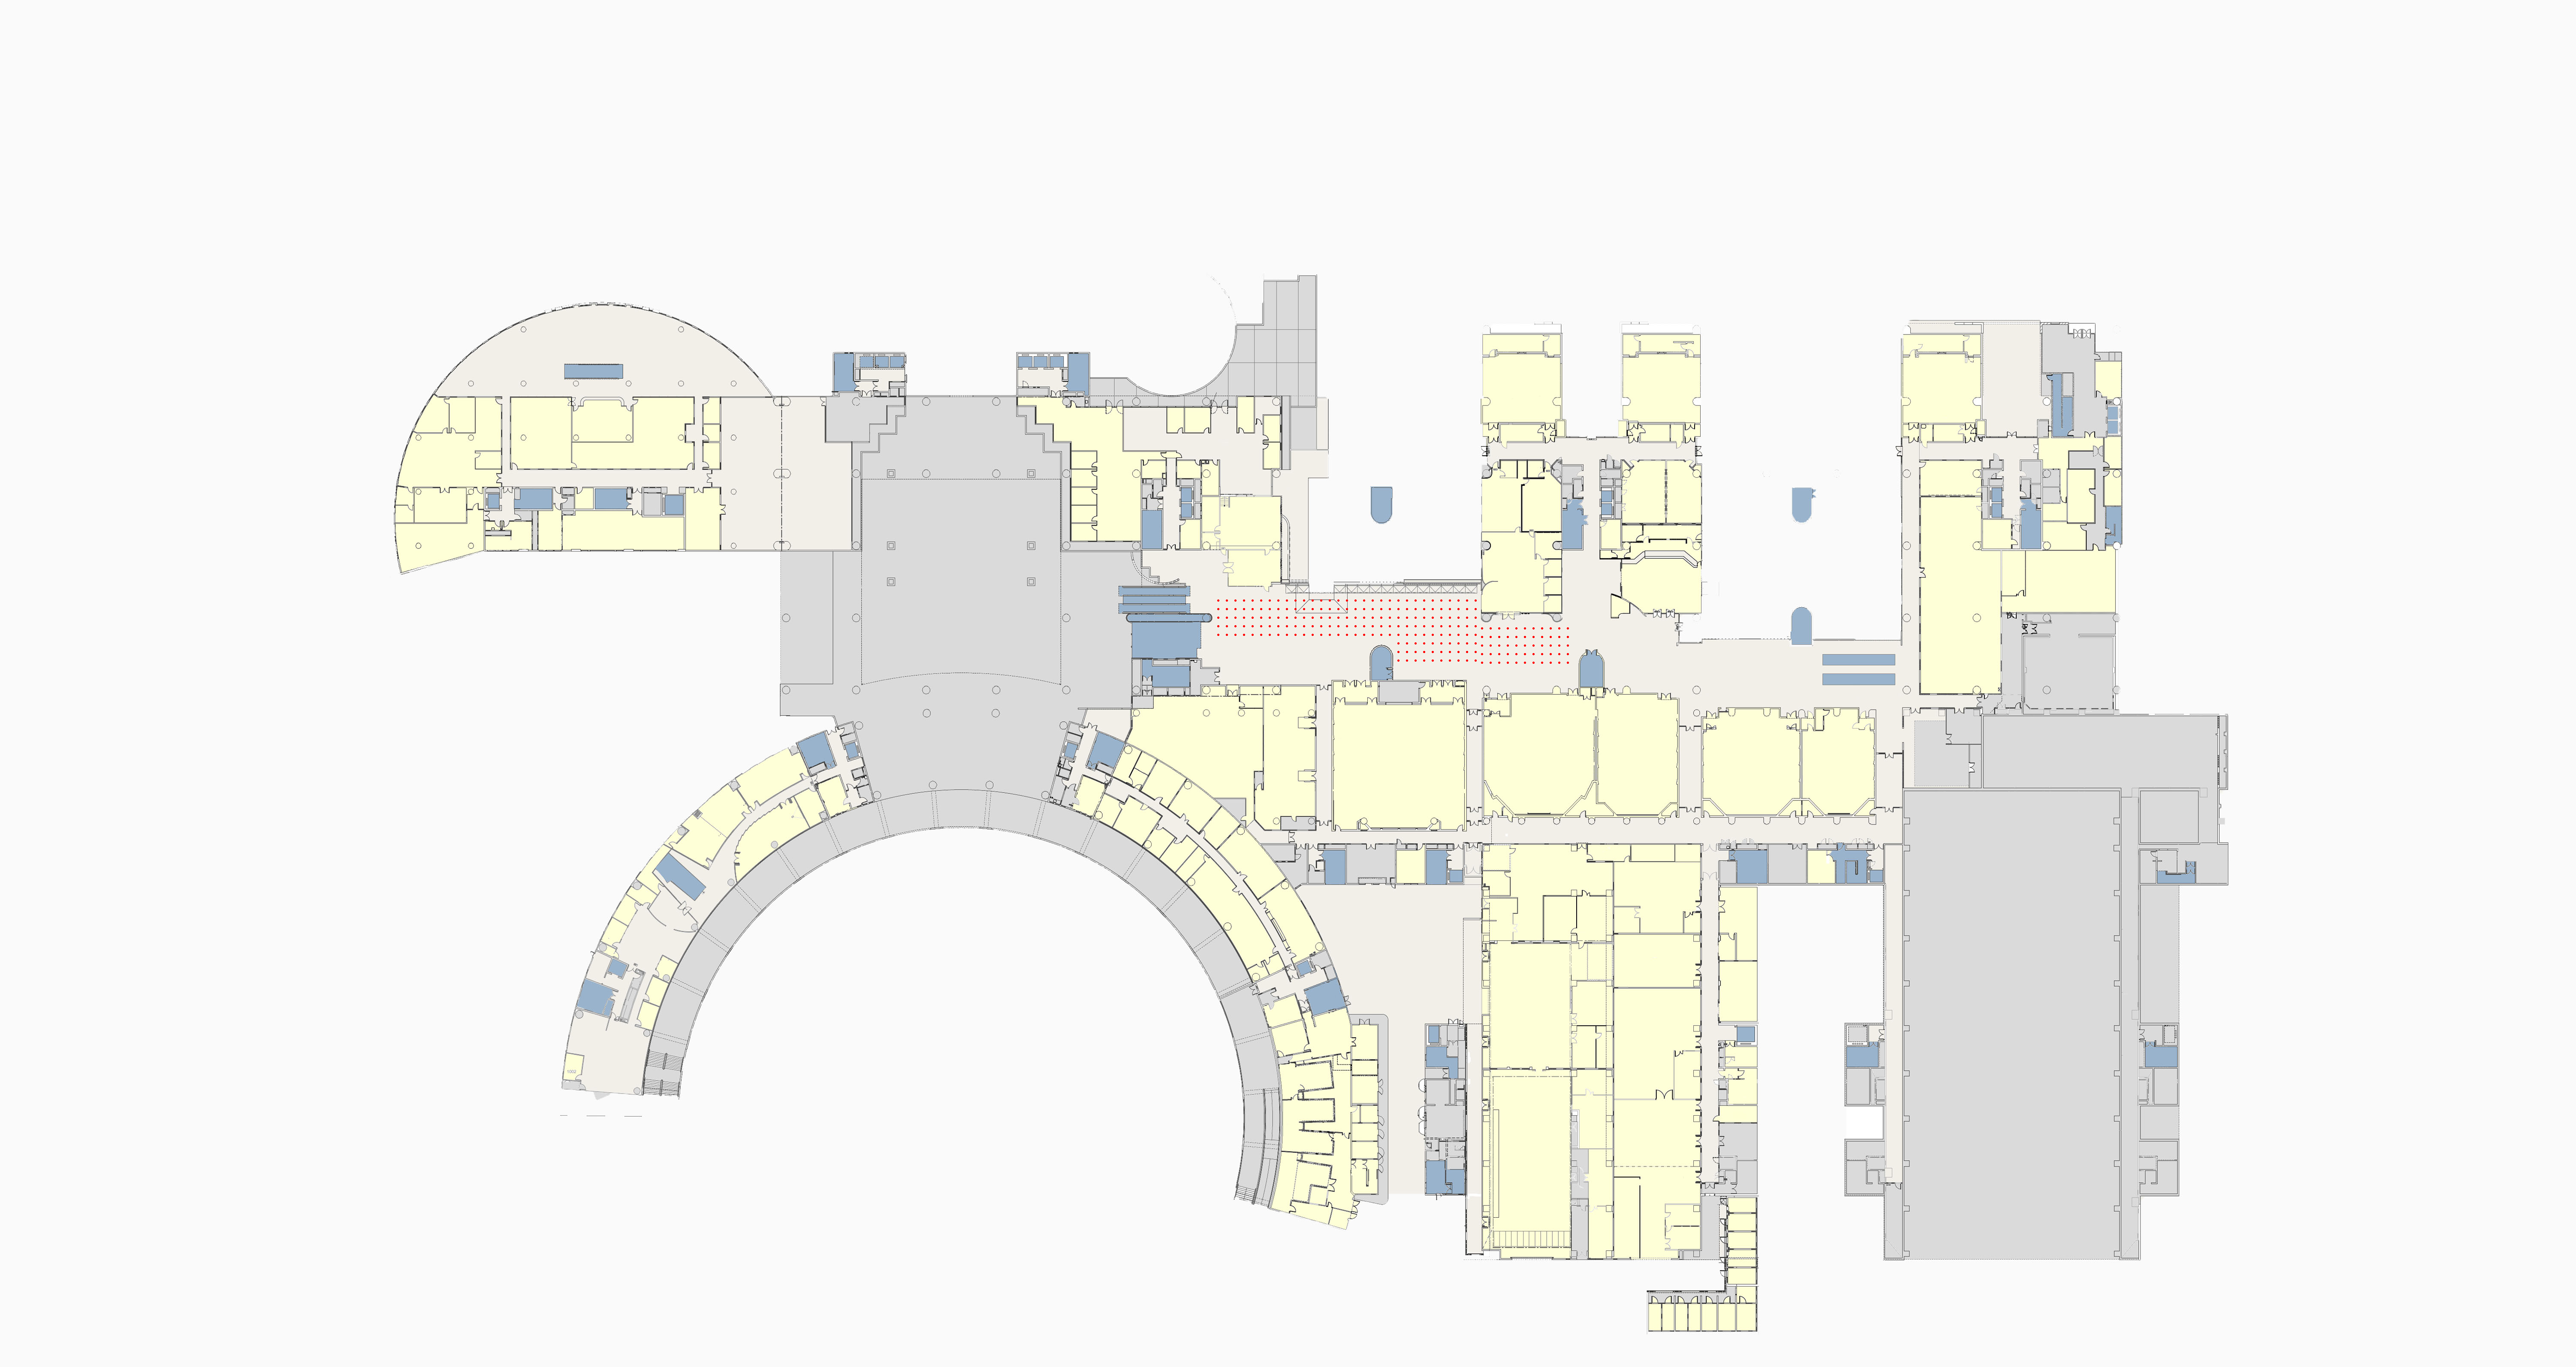

In [19]:
#Generate RP and draw RP
## Generate RPs
rp_locs = generate_line_grid(constraints1, gridsize) + generate_filled_grid(constraints2, gridsize)
rp_locs = list(set(rp_locs))
im = Image.open(map_path)
draw = ImageDraw.Draw(im)
r = 2
for j in range(0, len(rp_locs)):
    draw.ellipse((rp_locs[j][0]-r, rp_locs[j][1]-r, rp_locs[j][0]+r, rp_locs[j][1]+r), fill=(255, 0, 0, 255))
im.save(os.path.join(log_dir, '%s_grid.jpg' % site_name))
display(im)

In [16]:

# Load data, preprocess
fp_features, fp_locs, ap_list1 = read_wifi_fingerprint(glob.glob(os.path.join(dataset_dir, 'n*_WiFi.txt')))
test_features, test_locs, ap_list2 = read_wifi_fingerprint(glob.glob(os.path.join(dataset_dir2, 'm*_WiFi.txt')))
#print(fp_features.shape, test_features.shape)
#print(fp_features)
'''
if os.path.exists(os.path.join(log_dir, 'preprocessor')):
    with open(os.path.join(log_dir, 'preprocessor'), 'rb') as f:
        preprocessor = pickle.load(f)
else:
'''
preprocessor = WiFiPreprocessor()
y = preprocessor.fit(fp_features, fp_locs, ap_list1, ap_list2, rp_locs)
preprocessor.save(log_dir)
im = Image.open(map_path)
draw = ImageDraw.Draw(im)
i = 0
prevPred = [y[0][0],y[0][1]]
for yy in y:
    if i % 5==0:
#draw.line((pred[0], pred[1], truth[0], truth[1]), fill=256)
        draw.line((prevPred[0],prevPred[1],yy[0],yy[1]),fill=256)
        prevPred = yy
    i+=1
im.show()
im.save(os.path.join(log_dir, '%s_wifi_y.jpg' % site_name))

fp_features = preprocessor.preprocess(fp_features, ap_list1).astype(np.float32)
test_features = preprocessor.preprocess(test_features, ap_list2).astype(np.float32)
print(fp_features.shape, test_features.shape)

if not os.path.exists(os.path.join(log_dir, 'inout')):
    inout = InOutClassifier()
    inout.train(fp_features)
    inout.save(log_dir)

../data/HKUST_1F_Path2\naturally_HKUST_1F_15a14e2516f3f594_2840_1490_3440_1405_1603010259111_WiFi.txt
../data/HKUST_1F_Path2_2\middle_HKUST_1F_15a14e2516f3f594_2840_1490_3440_1405_1606264096627_WiFi.txt
before feature mapping X:
[[  0.   0.   0. ... -73. -71. -71.]
 [  0.   0.   0. ... -73. -71. -71.]
 [  0.   0.   0. ... -73. -71. -71.]
 ...
 [  0.   0. -62. ...   0.   0.   0.]
 [  0.   0. -62. ...   0.   0.   0.]
 [  0.   0. -62. ...   0.   0.   0.]]
after feature mapping:
[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0. -62. ...   0.   0.   0.]
 [  0.   0. -62. ...   0.   0.   0.]
 [  0.   0. -62. ...   0.   0.   0.]]
after feature scaling:
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.58333333 ... 0.    

mi
[1.00179722 0.05752652 2.28946089 2.35299892 1.52621417 2.51331942
 0.09250873 0.18165181 0.09213733 0.10846752 0.09064355 0.07826984
 0.10480013 0.18348642 0.16692942 2.55580519 1.91548275 3.02414478
 2.82162696 0.86919785 0.26000884 0.99665919 0.85425961 1.086738
 0.70162838 1.20748119 1.24860419 2.56972853 1.48095065 2.59093249
 2.60250902 2.16466943 1.55634694 2.28306369 2.21719255 2.3103652
 1.80809723 2.55487059 2.62674341 2.74157211 2.12302714 2.77658358
 2.71589055 0.1948167  0.04359225 0.19606599 0.62847248 0.27546313
 0.68870182 0.68198769 0.92666887 0.57594739 0.18381569 0.12327743
 0.25850395 0.33743424 1.59957124 1.01048243 1.72775324 1.75207202
 0.4266783  0.29579413 0.98464655 0.96141687 0.87445974 1.01412895
 0.70059201 0.33357193 0.32158257 0.29498844 0.2886004  0.2438109
 0.34111969 0.66779982 0.75400479 0.05795786 1.65948223 1.41046833
 1.60752055 0.66623316 1.57727842 0.85167699 1.08020035 0.33879004
 0.07931446]
np.percentile(mi, self.q)
0.2342619200384457
[ Tru

In [12]:
import pandas as pd
pd.DataFrame(fp_features)
print(pd.DataFrame(fp_features))

       0         1         2         3         4    5    6    7    8   \
0     0.0  0.000000  0.078125  0.000000  0.177083  0.0  0.0  0.0  0.0   
1     0.0  0.000000  0.078125  0.000000  0.177083  0.0  0.0  0.0  0.0   
2     0.0  0.000000  0.078125  0.000000  0.177083  0.0  0.0  0.0  0.0   
3     0.0  0.000000  0.078125  0.000000  0.177083  0.0  0.0  0.0  0.0   
4     0.0  0.000000  0.078125  0.000000  0.177083  0.0  0.0  0.0  0.0   
...   ...       ...       ...       ...       ...  ...  ...  ...  ...   
2022  0.0  0.145833  0.062500  0.065972  0.052083  0.0  0.0  0.0  0.0   
2023  0.0  0.145833  0.062500  0.065972  0.052083  0.0  0.0  0.0  0.0   
2024  0.0  0.145833  0.062500  0.065972  0.052083  0.0  0.0  0.0  0.0   
2025  0.0  0.145833  0.062500  0.065972  0.052083  0.0  0.0  0.0  0.0   
2026  0.0  0.145833  0.062500  0.065972  0.052083  0.0  0.0  0.0  0.0   

            9   ...   34        35        36   37   38   39   40   41   42  \
0     0.000000  ...  0.0  0.000000  0.000000 

In [18]:

rp_features = compute_reference_features(rp_locs, fp_features, fp_locs, gridsize=gridsize).astype(np.float32)
with open(os.path.join(log_dir, 'grid.txt'), 'w') as f:
    for rp_loc, rp_feature in zip(rp_locs, rp_features):
        f.write("%d %d %s\n" % (rp_loc[0], rp_loc[1], ' '.join([str(x) for x in rp_feature])))

train_ds = tf.data.Dataset.from_tensor_slices((fp_features, fp_locs)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((test_features, test_locs)).shuffle(10000).batch(1)
#train_ds = tf.data.Dataset.from_tensor_slices((fp_features, fp_locs)).batch(batch_size)
#test_ds = tf.data.Dataset.from_tensor_slices((test_features, test_locs)).batch(1)
#############################################################################################################
n_feature = fp_features.shape[1]
net = WifiNetwork(n_feature, rp_locs, rp_features, n_layers=n_layers, embedding_dim=d)

train_loss = tf.keras.metrics.Mean(name='train_loss')
reg_loss = tf.keras.metrics.Mean(name='regularization_loss')
loc_loss = tf.keras.metrics.Mean(name='localization_loss')
test_accuracy = tf.keras.metrics.Mean(name='test_accuracy')

if test:
    if os.path.exists(os.path.join(log_dir, 'saved_model.pb')):
        net = tf.saved_model.load(log_dir)
else:
    # Pretrain
    for i in range(n_layers):
        pretrain_step = net.pretrain_wrapper()
        for epoch in range(n_epochs):
            train_loss.reset_states()
            reg_loss.reset_states()
            for x, y in train_ds:
                t_loss, r_loss = pretrain_step(x, i)
                train_loss(t_loss)
                reg_loss(r_loss)
            print('Epoch {}, Training Loss: {}, Reg. Loss: {}'.format(epoch+1, train_loss.result(), reg_loss.result()))

    for epoch in range(n_epochs * 2):
        train_loss.reset_states()
        reg_loss.reset_states()
        loc_loss.reset_states()
        for x, y in train_ds:
            t_loss, r_loss, a_loss = net.train_step(x, y)
            train_loss(t_loss)
            reg_loss(r_loss)
            loc_loss(a_loss)
        print('Epoch {}, Training Loss: {}, Loc. Loss: {}, Reg. Loss: {}'.format(epoch + 1, train_loss.result(), loc_loss.result(), reg_loss.result()))

    signature = net.predict.get_concrete_function(x=tf.TensorSpec(shape=[None, n_feature], dtype=tf.float32))
    tf.saved_model.save(net, log_dir, signature)

rp_embeddings = net.predict(rp_features)
print("rp_embeddings")
print(rp_embeddings)
predictions, truths = [], []
error = 0
i = 0
for x, y in test_ds:
    if y[0].numpy()[1] < 9999:
        out = net.predict(x)
        sim = tf.norm(rp_embeddings - out, axis=1)
        prob1 = tf.exp(-sim ** 2 / 2)
        prob = prob1 / tf.math.reduce_sum(prob1)
        pred = tf.math.reduce_sum(prob[:, tf.newaxis] * rp_locs, axis=0)
        pred = rp_locs[tf.argmax(prob)]
        truth = y[0].numpy()
        acc = tf.norm(truth - pred)
        error += np.sqrt((truth[0] - pred[0])**2 + (truth[1] - pred[1])**2)
        i+=1
        test_accuracy(acc)
        predictions.append(pred)
        truths.append(truth)
print(error/i)
print("Accuracy: {}".format(test_accuracy.result()))
print("actual predictions")
print(predictions)
im = Image.open(map_path)
draw = ImageDraw.Draw(im)
i = 0
prevPred = [predictions[0][0],predictions[0][1]]
for pred, truth in zip(predictions, truths):
    if i % 5==0:
    #draw.line((pred[0], pred[1], truth[0], truth[1]), fill=256)
        draw.line((prevPred[0],prevPred[1],pred[0],pred[1]),fill=256)
        prevPred = pred
    i+=1
im.show()
im.save(os.path.join(log_dir, '%s_wifi.jpg' % site_name))

np.savetxt(os.path.join(log_dir, 'weight.txt'), np.ones(len(rp_locs)))

Epoch 1, Training Loss: 0.21165603399276733, Reg. Loss: 0.002912303898483515
Epoch 2, Training Loss: 0.17979785799980164, Reg. Loss: 0.0028619463555514812
Epoch 3, Training Loss: 0.09488473832607269, Reg. Loss: 0.0028312671929597855
Epoch 4, Training Loss: 0.03807627409696579, Reg. Loss: 0.0028193998150527477
Epoch 5, Training Loss: 0.01990341767668724, Reg. Loss: 0.0028156531043350697
Epoch 6, Training Loss: 0.019392233341932297, Reg. Loss: 0.002807664917781949
Epoch 7, Training Loss: 0.019461676478385925, Reg. Loss: 0.00279396609403193
Epoch 8, Training Loss: 0.019350260496139526, Reg. Loss: 0.0027750907465815544
Epoch 9, Training Loss: 0.0192711278796196, Reg. Loss: 0.002751779742538929
Epoch 10, Training Loss: 0.019279368221759796, Reg. Loss: 0.0027249627746641636
Epoch 11, Training Loss: 0.01925702393054962, Reg. Loss: 0.002695552073419094
Epoch 12, Training Loss: 0.019232554361224174, Reg. Loss: 0.002664286643266678
Epoch 13, Training Loss: 0.019237492233514786, Reg. Loss: 0.0026

Epoch 106, Training Loss: 0.01923118159174919, Reg. Loss: 0.0012458284618332982
Epoch 107, Training Loss: 0.019228611141443253, Reg. Loss: 0.001238419907167554
Epoch 108, Training Loss: 0.019233619794249535, Reg. Loss: 0.001231068861670792
Epoch 109, Training Loss: 0.019231436774134636, Reg. Loss: 0.0012237741611897945
Epoch 110, Training Loss: 0.01923251338303089, Reg. Loss: 0.0012165363878011703
Epoch 111, Training Loss: 0.019230671226978302, Reg. Loss: 0.001209355192258954
Epoch 112, Training Loss: 0.019235283136367798, Reg. Loss: 0.0012022294104099274
Epoch 113, Training Loss: 0.019232410937547684, Reg. Loss: 0.001195157878100872
Epoch 114, Training Loss: 0.019229769706726074, Reg. Loss: 0.0011881381506100297
Epoch 115, Training Loss: 0.01923588290810585, Reg. Loss: 0.0011811687145382166
Epoch 116, Training Loss: 0.01923312060534954, Reg. Loss: 0.00117424875497818
Epoch 117, Training Loss: 0.019233904778957367, Reg. Loss: 0.0011673804838210344
Epoch 118, Training Loss: 0.0192279554

Epoch 209, Training Loss: 0.019192274659872055, Reg. Loss: 0.0006946927169337869
Epoch 210, Training Loss: 0.019225258380174637, Reg. Loss: 0.0006923041073605418
Epoch 211, Training Loss: 0.01916622184216976, Reg. Loss: 0.0006895968108437955
Epoch 212, Training Loss: 0.018990540876984596, Reg. Loss: 0.0006883032619953156
Epoch 213, Training Loss: 0.018396195024251938, Reg. Loss: 0.0006910874508321285
Epoch 214, Training Loss: 0.01748371124267578, Reg. Loss: 0.0006987245287746191
Epoch 215, Training Loss: 0.017675090581178665, Reg. Loss: 0.0007002669735811651
Epoch 216, Training Loss: 0.0183249544352293, Reg. Loss: 0.0007021658238954842
Epoch 217, Training Loss: 0.018189789727330208, Reg. Loss: 0.0007044470403343439
Epoch 218, Training Loss: 0.017003925517201424, Reg. Loss: 0.0007054052548483014
Epoch 219, Training Loss: 0.016201946884393692, Reg. Loss: 0.0007052188739180565
Epoch 220, Training Loss: 0.015658698976039886, Reg. Loss: 0.0007046368555165827
Epoch 221, Training Loss: 0.0153

Epoch 310, Training Loss: 0.006012728437781334, Reg. Loss: 0.0007594524649903178
Epoch 311, Training Loss: 0.00608793506398797, Reg. Loss: 0.0007586689898744226
Epoch 312, Training Loss: 0.005986609496176243, Reg. Loss: 0.0007601578254252672
Epoch 313, Training Loss: 0.006201343145221472, Reg. Loss: 0.0007610427564941347
Epoch 314, Training Loss: 0.005921350326389074, Reg. Loss: 0.0007606871658936143
Epoch 315, Training Loss: 0.0059744808822870255, Reg. Loss: 0.0007583587430417538
Epoch 316, Training Loss: 0.006275516003370285, Reg. Loss: 0.0007567093707621098
Epoch 317, Training Loss: 0.006115792319178581, Reg. Loss: 0.0007574253249913454
Epoch 318, Training Loss: 0.005784740671515465, Reg. Loss: 0.0007573517505079508
Epoch 319, Training Loss: 0.006009850651025772, Reg. Loss: 0.0007542630191892385
Epoch 320, Training Loss: 0.006222969852387905, Reg. Loss: 0.0007522389059886336
Epoch 321, Training Loss: 0.0058425599709153175, Reg. Loss: 0.0007528595742769539
Epoch 322, Training Loss: 0

Epoch 417, Training Loss: 0.00492581631988287, Reg. Loss: 0.0007142438553273678
Epoch 418, Training Loss: 0.004895497113466263, Reg. Loss: 0.0007134444313123822
Epoch 419, Training Loss: 0.0049440572038292885, Reg. Loss: 0.0007129386067390442
Epoch 420, Training Loss: 0.004748963285237551, Reg. Loss: 0.0007129109581001103
Epoch 421, Training Loss: 0.0049088504165410995, Reg. Loss: 0.0007123950636014342
Epoch 422, Training Loss: 0.004835909232497215, Reg. Loss: 0.0007128086872398853
Epoch 423, Training Loss: 0.004810576792806387, Reg. Loss: 0.0007121406961232424
Epoch 424, Training Loss: 0.004805419128388166, Reg. Loss: 0.000711523462086916
Epoch 425, Training Loss: 0.004666429478675127, Reg. Loss: 0.0007113785250112414
Epoch 426, Training Loss: 0.004810243844985962, Reg. Loss: 0.0007108886493369937
Epoch 427, Training Loss: 0.004854933358728886, Reg. Loss: 0.0007109999423846602
Epoch 428, Training Loss: 0.004771561827510595, Reg. Loss: 0.0007107023266144097
Epoch 429, Training Loss: 0.

Epoch 24, Training Loss: 0.01923028752207756, Reg. Loss: 0.002010288881137967
Epoch 25, Training Loss: 0.019233424216508865, Reg. Loss: 0.0019875378347933292
Epoch 26, Training Loss: 0.0192330963909626, Reg. Loss: 0.0019656114745885134
Epoch 27, Training Loss: 0.019232220947742462, Reg. Loss: 0.001944438903592527
Epoch 28, Training Loss: 0.01923256739974022, Reg. Loss: 0.0019239558605477214
Epoch 29, Training Loss: 0.019233491271734238, Reg. Loss: 0.0019041209015995264
Epoch 30, Training Loss: 0.01923384703695774, Reg. Loss: 0.001884912489913404
Epoch 31, Training Loss: 0.019230952486395836, Reg. Loss: 0.0018662401707842946
Epoch 32, Training Loss: 0.019234497100114822, Reg. Loss: 0.0018480628496035933
Epoch 33, Training Loss: 0.019231943413615227, Reg. Loss: 0.0018303471151739359
Epoch 34, Training Loss: 0.01923329196870327, Reg. Loss: 0.0018130643293261528
Epoch 35, Training Loss: 0.01923125609755516, Reg. Loss: 0.0017961910925805569
Epoch 36, Training Loss: 0.01923369988799095, Reg.

Epoch 127, Training Loss: 0.019235428422689438, Reg. Loss: 0.0009633740992285311
Epoch 128, Training Loss: 0.019229229539632797, Reg. Loss: 0.0009577869204804301
Epoch 129, Training Loss: 0.019231591373682022, Reg. Loss: 0.0009522409527562559
Epoch 130, Training Loss: 0.01923278160393238, Reg. Loss: 0.0009467351483181119
Epoch 131, Training Loss: 0.019230809062719345, Reg. Loss: 0.0009412674698978662
Epoch 132, Training Loss: 0.019231703132390976, Reg. Loss: 0.0009358373354189098
Epoch 133, Training Loss: 0.019240103662014008, Reg. Loss: 0.0009304368868470192
Epoch 134, Training Loss: 0.01923196017742157, Reg. Loss: 0.0009250650182366371
Epoch 135, Training Loss: 0.019232776015996933, Reg. Loss: 0.0009197354083880782
Epoch 136, Training Loss: 0.019230669364333153, Reg. Loss: 0.00091443897690624
Epoch 137, Training Loss: 0.01923239603638649, Reg. Loss: 0.0009091751999221742
Epoch 138, Training Loss: 0.019232962280511856, Reg. Loss: 0.0009039519354701042
Epoch 139, Training Loss: 0.01923

Epoch 229, Training Loss: 0.0060118092224001884, Reg. Loss: 0.0009365276200696826
Epoch 230, Training Loss: 0.005779104772955179, Reg. Loss: 0.0009379440452903509
Epoch 231, Training Loss: 0.005947975441813469, Reg. Loss: 0.0009368726750835776
Epoch 232, Training Loss: 0.0058395881205797195, Reg. Loss: 0.0009361905977129936
Epoch 233, Training Loss: 0.00577711733058095, Reg. Loss: 0.0009352645720355213
Epoch 234, Training Loss: 0.005758149549365044, Reg. Loss: 0.0009331739274784923
Epoch 235, Training Loss: 0.005661088041961193, Reg. Loss: 0.000931667338591069
Epoch 236, Training Loss: 0.005558370146900415, Reg. Loss: 0.0009290663874708116
Epoch 237, Training Loss: 0.005524888634681702, Reg. Loss: 0.0009276748169213533
Epoch 238, Training Loss: 0.005480249412357807, Reg. Loss: 0.0009261934319511056
Epoch 239, Training Loss: 0.005507948808372021, Reg. Loss: 0.0009236347395926714
Epoch 240, Training Loss: 0.005444454029202461, Reg. Loss: 0.0009206883842125535
Epoch 241, Training Loss: 0.

Epoch 332, Training Loss: 0.00484697800129652, Reg. Loss: 0.0007505773101001978
Epoch 333, Training Loss: 0.004807518795132637, Reg. Loss: 0.0007484544767066836
Epoch 334, Training Loss: 0.004647678229957819, Reg. Loss: 0.0007446144009009004
Epoch 335, Training Loss: 0.004610022064298391, Reg. Loss: 0.0007421851041726768
Epoch 336, Training Loss: 0.004724600818008184, Reg. Loss: 0.0007419450557790697
Epoch 337, Training Loss: 0.004655302502214909, Reg. Loss: 0.000741443014703691
Epoch 338, Training Loss: 0.004359525628387928, Reg. Loss: 0.0007395203574560583
Epoch 339, Training Loss: 0.004852195270359516, Reg. Loss: 0.0007379163289442658
Epoch 340, Training Loss: 0.004738520830869675, Reg. Loss: 0.0007389140664599836
Epoch 341, Training Loss: 0.004698349162936211, Reg. Loss: 0.0007375025888904929
Epoch 342, Training Loss: 0.00473198015242815, Reg. Loss: 0.000735334528144449
Epoch 343, Training Loss: 0.00447804993018508, Reg. Loss: 0.000733777997083962
Epoch 344, Training Loss: 0.004770

Epoch 436, Training Loss: 0.004612134303897619, Reg. Loss: 0.0006579310866072774
Epoch 437, Training Loss: 0.004559357650578022, Reg. Loss: 0.0006574474973604083
Epoch 438, Training Loss: 0.004579043015837669, Reg. Loss: 0.0006563567440025508
Epoch 439, Training Loss: 0.004640203434973955, Reg. Loss: 0.0006562123307958245
Epoch 440, Training Loss: 0.004544875584542751, Reg. Loss: 0.0006539435125887394
Epoch 441, Training Loss: 0.004491924308240414, Reg. Loss: 0.0006515170680359006
Epoch 442, Training Loss: 0.0044598039239645, Reg. Loss: 0.0006512447725981474
Epoch 443, Training Loss: 0.004216969013214111, Reg. Loss: 0.0006510454113595188
Epoch 444, Training Loss: 0.004595672711730003, Reg. Loss: 0.0006500817835330963
Epoch 445, Training Loss: 0.004607142880558968, Reg. Loss: 0.0006505130440928042
Epoch 446, Training Loss: 0.004466874524950981, Reg. Loss: 0.000650212517939508
Epoch 447, Training Loss: 0.004647854715585709, Reg. Loss: 0.0006491887615993619
Epoch 448, Training Loss: 0.004

Epoch 34, Training Loss: 0.005053529981523752, Loc. Loss: 0.0, Reg. Loss: 0.0011894693598151207
Epoch 35, Training Loss: 0.005017412360757589, Loc. Loss: 0.0, Reg. Loss: 0.0011839930666610599
Epoch 36, Training Loss: 0.005017736926674843, Loc. Loss: 0.0, Reg. Loss: 0.0011780401691794395
Epoch 37, Training Loss: 0.005098809488117695, Loc. Loss: 0.0, Reg. Loss: 0.0011718736495822668
Epoch 38, Training Loss: 0.005015230271965265, Loc. Loss: 0.0, Reg. Loss: 0.0011683881748467684
Epoch 39, Training Loss: 0.005071255378425121, Loc. Loss: 0.0, Reg. Loss: 0.0011631001252681017
Epoch 40, Training Loss: 0.004828913137316704, Loc. Loss: 0.0, Reg. Loss: 0.0011558127589523792
Epoch 41, Training Loss: 0.004882615990936756, Loc. Loss: 0.0, Reg. Loss: 0.001149593386799097
Epoch 42, Training Loss: 0.004852022975683212, Loc. Loss: 0.0, Reg. Loss: 0.0011442177928984165
Epoch 43, Training Loss: 0.005011534783989191, Loc. Loss: 0.0, Reg. Loss: 0.0011373220477253199
Epoch 44, Training Loss: 0.00470743793994

Epoch 123, Training Loss: 0.0046948520466685295, Loc. Loss: 0.0, Reg. Loss: 0.0009789520408958197
Epoch 124, Training Loss: 0.004866487346589565, Loc. Loss: 0.0, Reg. Loss: 0.0009775403887033463
Epoch 125, Training Loss: 0.004768539220094681, Loc. Loss: 0.0, Reg. Loss: 0.000980457873083651
Epoch 126, Training Loss: 0.004725877195596695, Loc. Loss: 0.0, Reg. Loss: 0.0009791210759431124
Epoch 127, Training Loss: 0.004756482783704996, Loc. Loss: 0.0, Reg. Loss: 0.0009787119925022125
Epoch 128, Training Loss: 0.004472642205655575, Loc. Loss: 0.0, Reg. Loss: 0.0009775562211871147
Epoch 129, Training Loss: 0.004757992457598448, Loc. Loss: 0.0, Reg. Loss: 0.0009766585426405072
Epoch 130, Training Loss: 0.004365425556898117, Loc. Loss: 0.0, Reg. Loss: 0.0009786300361156464
Epoch 131, Training Loss: 0.004723892547190189, Loc. Loss: 0.0, Reg. Loss: 0.0009749808814376593
Epoch 132, Training Loss: 0.004650344606488943, Loc. Loss: 0.0, Reg. Loss: 0.0009761343826539814
Epoch 133, Training Loss: 0.00

Epoch 209, Training Loss: 0.004796815570443869, Loc. Loss: 0.0, Reg. Loss: 0.0009562566410750151
Epoch 210, Training Loss: 0.004663511179387569, Loc. Loss: 0.0, Reg. Loss: 0.000951156544033438
Epoch 211, Training Loss: 0.004782228730618954, Loc. Loss: 0.0, Reg. Loss: 0.0009517328580841422
Epoch 212, Training Loss: 0.0045943548902869225, Loc. Loss: 0.0, Reg. Loss: 0.0009546830551698804
Epoch 213, Training Loss: 0.004756631329655647, Loc. Loss: 0.0, Reg. Loss: 0.0009492088574916124
Epoch 214, Training Loss: 0.00487181730568409, Loc. Loss: 0.0, Reg. Loss: 0.0009518321021459997
Epoch 215, Training Loss: 0.004796532914042473, Loc. Loss: 0.0, Reg. Loss: 0.000959957716986537
Epoch 216, Training Loss: 0.004786014091223478, Loc. Loss: 0.0, Reg. Loss: 0.0009612608700990677
Epoch 217, Training Loss: 0.004667441360652447, Loc. Loss: 0.0, Reg. Loss: 0.0009620832279324532
Epoch 218, Training Loss: 0.004676738753914833, Loc. Loss: 0.0, Reg. Loss: 0.0009615211747586727
Epoch 219, Training Loss: 0.0046

Epoch 295, Training Loss: 0.004425284452736378, Loc. Loss: 0.0, Reg. Loss: 0.0009282443206757307
Epoch 296, Training Loss: 0.004345599561929703, Loc. Loss: 0.0, Reg. Loss: 0.000929131405428052
Epoch 297, Training Loss: 0.004230922088027, Loc. Loss: 0.0, Reg. Loss: 0.0009305269340984523
Epoch 298, Training Loss: 0.00404497142881155, Loc. Loss: 0.0, Reg. Loss: 0.0009258289355784655
Epoch 299, Training Loss: 0.004704096354544163, Loc. Loss: 0.0, Reg. Loss: 0.000924863270483911
Epoch 300, Training Loss: 0.00470338761806488, Loc. Loss: 0.0, Reg. Loss: 0.0009298655786551535
Epoch 301, Training Loss: 0.004561975598335266, Loc. Loss: 0.0, Reg. Loss: 0.000928712310269475
Epoch 302, Training Loss: 0.004536704625934362, Loc. Loss: 0.0, Reg. Loss: 0.0009308252483606339
Epoch 303, Training Loss: 0.004445764236152172, Loc. Loss: 0.0, Reg. Loss: 0.0009319058153778315
Epoch 304, Training Loss: 0.004614677280187607, Loc. Loss: 0.0, Reg. Loss: 0.0009282423998229206
Epoch 305, Training Loss: 0.0045286938

Epoch 383, Training Loss: 0.004361463710665703, Loc. Loss: 0.0, Reg. Loss: 0.0009212964214384556
Epoch 384, Training Loss: 0.004211497493088245, Loc. Loss: 0.0, Reg. Loss: 0.0009220511419698596
Epoch 385, Training Loss: 0.0043505532667040825, Loc. Loss: 0.0, Reg. Loss: 0.0009219751227647066
Epoch 386, Training Loss: 0.00416975375264883, Loc. Loss: 0.0, Reg. Loss: 0.0009218998020514846
Epoch 387, Training Loss: 0.003914668224751949, Loc. Loss: 0.0, Reg. Loss: 0.0009208251722157001
Epoch 388, Training Loss: 0.004452905151993036, Loc. Loss: 0.0, Reg. Loss: 0.0009198939660564065
Epoch 389, Training Loss: 0.0043212901800870895, Loc. Loss: 0.0, Reg. Loss: 0.0009222379885613918
Epoch 390, Training Loss: 0.004304645583033562, Loc. Loss: 0.0, Reg. Loss: 0.0009219838539138436
Epoch 391, Training Loss: 0.004405226092785597, Loc. Loss: 0.0, Reg. Loss: 0.0009223193046636879
Epoch 392, Training Loss: 0.004244041629135609, Loc. Loss: 0.0, Reg. Loss: 0.0009206626564264297
Epoch 393, Training Loss: 0.0

Epoch 467, Training Loss: 0.004142741672694683, Loc. Loss: 0.0, Reg. Loss: 0.000920912716537714
Epoch 468, Training Loss: 0.003849218599498272, Loc. Loss: 0.0, Reg. Loss: 0.0009199384367093444
Epoch 469, Training Loss: 0.003896476002410054, Loc. Loss: 0.0, Reg. Loss: 0.0009165789233520627
Epoch 470, Training Loss: 0.0038560936227440834, Loc. Loss: 0.0, Reg. Loss: 0.0009171387646347284
Epoch 471, Training Loss: 0.0042893122881650925, Loc. Loss: 0.0, Reg. Loss: 0.0009176410967484117
Epoch 472, Training Loss: 0.004324617795646191, Loc. Loss: 0.0, Reg. Loss: 0.0009205097449012101
Epoch 473, Training Loss: 0.004100356251001358, Loc. Loss: 0.0, Reg. Loss: 0.0009217074839398265
Epoch 474, Training Loss: 0.004374481737613678, Loc. Loss: 0.0, Reg. Loss: 0.000919208861887455
Epoch 475, Training Loss: 0.004069712478667498, Loc. Loss: 0.0, Reg. Loss: 0.000921920407563448
Epoch 476, Training Loss: 0.004338257946074009, Loc. Loss: 0.0, Reg. Loss: 0.0009214654564857483
Epoch 477, Training Loss: 0.004

Epoch 554, Training Loss: 0.004257175140082836, Loc. Loss: 0.0, Reg. Loss: 0.0009196968167088926
Epoch 555, Training Loss: 0.004077787511050701, Loc. Loss: 0.0, Reg. Loss: 0.0009165647788904607
Epoch 556, Training Loss: 0.003981185145676136, Loc. Loss: 0.0, Reg. Loss: 0.000915360520593822
Epoch 557, Training Loss: 0.003982136026024818, Loc. Loss: 0.0, Reg. Loss: 0.000916212098672986
Epoch 558, Training Loss: 0.004288391210138798, Loc. Loss: 0.0, Reg. Loss: 0.0009147809469141066
Epoch 559, Training Loss: 0.004290679004043341, Loc. Loss: 0.0, Reg. Loss: 0.0009166651871055365
Epoch 560, Training Loss: 0.0040298583917319775, Loc. Loss: 0.0, Reg. Loss: 0.000916172401048243
Epoch 561, Training Loss: 0.004131317138671875, Loc. Loss: 0.0, Reg. Loss: 0.0009169809054583311
Epoch 562, Training Loss: 0.004267409443855286, Loc. Loss: 0.0, Reg. Loss: 0.0009142705239355564
Epoch 563, Training Loss: 0.004359979182481766, Loc. Loss: 0.0, Reg. Loss: 0.0009184174123220146
Epoch 564, Training Loss: 0.0042

Epoch 642, Training Loss: 0.0037256740033626556, Loc. Loss: 0.0, Reg. Loss: 0.0009112623520195484
Epoch 643, Training Loss: 0.004238835535943508, Loc. Loss: 0.0, Reg. Loss: 0.0009106806246563792
Epoch 644, Training Loss: 0.004224643111228943, Loc. Loss: 0.0, Reg. Loss: 0.0009135217405855656
Epoch 645, Training Loss: 0.00415148725733161, Loc. Loss: 0.0, Reg. Loss: 0.0009118588641285896
Epoch 646, Training Loss: 0.0041433279402554035, Loc. Loss: 0.0, Reg. Loss: 0.000914220989216119
Epoch 647, Training Loss: 0.003919404000043869, Loc. Loss: 0.0, Reg. Loss: 0.000913533556740731
Epoch 648, Training Loss: 0.004040596541017294, Loc. Loss: 0.0, Reg. Loss: 0.0009125526994466782
Epoch 649, Training Loss: 0.0036876644007861614, Loc. Loss: 0.0, Reg. Loss: 0.0009122084593400359
Epoch 650, Training Loss: 0.0040677571669220924, Loc. Loss: 0.0, Reg. Loss: 0.0009111827239394188
Epoch 651, Training Loss: 0.0039930883795022964, Loc. Loss: 0.0, Reg. Loss: 0.0009122221963480115
Epoch 652, Training Loss: 0.

Epoch 729, Training Loss: 0.0036721625365316868, Loc. Loss: 0.0, Reg. Loss: 0.0009228729177266359
Epoch 730, Training Loss: 0.0039751967415213585, Loc. Loss: 0.0, Reg. Loss: 0.0009216993348672986
Epoch 731, Training Loss: 0.00407838262617588, Loc. Loss: 0.0, Reg. Loss: 0.0009220712818205357
Epoch 732, Training Loss: 0.003870924934744835, Loc. Loss: 0.0, Reg. Loss: 0.0009214532328769565
Epoch 733, Training Loss: 0.0038883830420672894, Loc. Loss: 0.0, Reg. Loss: 0.0009205053793266416
Epoch 734, Training Loss: 0.003859200980514288, Loc. Loss: 0.0, Reg. Loss: 0.000919413985684514
Epoch 735, Training Loss: 0.004099315032362938, Loc. Loss: 0.0, Reg. Loss: 0.0009224545792676508
Epoch 736, Training Loss: 0.0038758236914873123, Loc. Loss: 0.0, Reg. Loss: 0.0009239265928044915
Epoch 737, Training Loss: 0.004128053784370422, Loc. Loss: 0.0, Reg. Loss: 0.0009223795495927334
Epoch 738, Training Loss: 0.004047241061925888, Loc. Loss: 0.0, Reg. Loss: 0.0009231098229065537
Epoch 739, Training Loss: 0.

Epoch 818, Training Loss: 0.004112355411052704, Loc. Loss: 0.0, Reg. Loss: 0.0009270714945159853
Epoch 819, Training Loss: 0.003929961938410997, Loc. Loss: 0.0, Reg. Loss: 0.0009295183699578047
Epoch 820, Training Loss: 0.003831287380307913, Loc. Loss: 0.0, Reg. Loss: 0.0009267776040360332
Epoch 821, Training Loss: 0.0038536307401955128, Loc. Loss: 0.0, Reg. Loss: 0.0009241147781722248
Epoch 822, Training Loss: 0.004029105417430401, Loc. Loss: 0.0, Reg. Loss: 0.0009260067017748952
Epoch 823, Training Loss: 0.003828992135822773, Loc. Loss: 0.0, Reg. Loss: 0.0009260738734155893
Epoch 824, Training Loss: 0.003827146254479885, Loc. Loss: 0.0, Reg. Loss: 0.0009238215279765427
Epoch 825, Training Loss: 0.003800514619797468, Loc. Loss: 0.0, Reg. Loss: 0.0009236542391590774
Epoch 826, Training Loss: 0.004136631730943918, Loc. Loss: 0.0, Reg. Loss: 0.0009266225388273597
Epoch 827, Training Loss: 0.003574250265955925, Loc. Loss: 0.0, Reg. Loss: 0.0009267565328627825
Epoch 828, Training Loss: 0.0

Epoch 905, Training Loss: 0.0038167210295796394, Loc. Loss: 0.0, Reg. Loss: 0.0009567261440679431
Epoch 906, Training Loss: 0.0037897713482379913, Loc. Loss: 0.0, Reg. Loss: 0.0009541073814034462
Epoch 907, Training Loss: 0.0034337276592850685, Loc. Loss: 0.0, Reg. Loss: 0.0009535033022984862
Epoch 908, Training Loss: 0.003509026486426592, Loc. Loss: 0.0, Reg. Loss: 0.000953937298618257
Epoch 909, Training Loss: 0.0037826397456228733, Loc. Loss: 0.0, Reg. Loss: 0.0009554554126225412
Epoch 910, Training Loss: 0.003754260018467903, Loc. Loss: 0.0, Reg. Loss: 0.0009576338343322277
Epoch 911, Training Loss: 0.0037430194206535816, Loc. Loss: 0.0, Reg. Loss: 0.0009600662742741406
Epoch 912, Training Loss: 0.003436578903347254, Loc. Loss: 0.0, Reg. Loss: 0.0009602780919522047
Epoch 913, Training Loss: 0.003946254495531321, Loc. Loss: 0.0, Reg. Loss: 0.0009587443200871348
Epoch 914, Training Loss: 0.00399620458483696, Loc. Loss: 0.0, Reg. Loss: 0.0009601572528481483
Epoch 915, Training Loss: 0

Epoch 990, Training Loss: 0.003926179371774197, Loc. Loss: 0.0, Reg. Loss: 0.0009660812793299556
Epoch 991, Training Loss: 0.0038922519888728857, Loc. Loss: 0.0, Reg. Loss: 0.0009663052042014897
Epoch 992, Training Loss: 0.003405863419175148, Loc. Loss: 0.0, Reg. Loss: 0.0009631525026634336
Epoch 993, Training Loss: 0.003805265761911869, Loc. Loss: 0.0, Reg. Loss: 0.0009613719885237515
Epoch 994, Training Loss: 0.0037494609132409096, Loc. Loss: 0.0, Reg. Loss: 0.0009622222860343754
Epoch 995, Training Loss: 0.0039284564554691315, Loc. Loss: 0.0, Reg. Loss: 0.0009632855071686208
Epoch 996, Training Loss: 0.003978944383561611, Loc. Loss: 0.0, Reg. Loss: 0.0009658060153014958
Epoch 997, Training Loss: 0.00390916783362627, Loc. Loss: 0.0, Reg. Loss: 0.0009643554803915322
Epoch 998, Training Loss: 0.0036129720974713564, Loc. Loss: 0.0, Reg. Loss: 0.0009641817305237055
Epoch 999, Training Loss: 0.0033552690874785185, Loc. Loss: 0.0, Reg. Loss: 0.000963183178100735
Epoch 1000, Training Loss: 